# Spiral Sequence Development with Pypulseq (Marten Veldmann, DZNE Bonn)

In [39]:
import numpy as np

# Pypulseq
from pypulseq.make_arbitrary_grad import make_arbitrary_grad
from pypulseq.Sequence.sequence import Sequence
from pypulseq.make_adc import make_adc
from pypulseq.make_sinc_pulse import make_sinc_pulse
from pypulseq.make_trap_pulse import make_trapezoid
from pypulseq.make_delay import make_delay
from pypulseq.opts import Opts

# spiral trajectory (in-house development)
import spiraltraj

# rotation of spiral gradients
def rot_grad(gx, gy, phi):
    gx_rot = np.cos(phi)*gx-np.sin(phi)*gy
    gy_rot = np.sin(phi)*gx+np.cos(phi)*gy    
    
    return gx_rot, gy_rot

In [40]:
# set system limits
max_slew = 200 # maximum gradient slewrate
max_grad = 70  # maximum gradient amplitude

system = Opts(max_grad=max_grad, grad_unit='mT/m', max_slew=max_slew, slew_unit='T/m/s', rf_ringdown_time=30e-6,
              rf_dead_time=100e-6)

In [41]:
# make rf pulse, slice selection gradient & rewinder
flip_angle      = 15 # [°]
rf_duration     = 3  # [ms] 
slice_thickness = 2  # [mm]

rf, gz, gz_rew = make_sinc_pulse(flip_angle=flip_angle*np.pi/180, system=system, duration=rf_duration*1e-3, 
                                 slice_thickness=slice_thickness*1e-3, apodization=0.5, time_bw_product=5, 
                                 use='excitation')

# calculate spiral
nitlv      = 3   # spiral interleaves
fov        = 192 # field of view [mm]
res        = 1   # in-plane resolution [mm]
spiraltype = 1   # spiral out
min_rise   = 6   # minimum gradient rise time 
max_amp    = 42  # maximum gradient amplitude

spiral_calc = spiraltraj.calc_traj(nitlv=nitlv, fov=fov, res=res, spiraltype=spiraltype, 
                                   min_rise=min_rise, max_amp=max_amp)

# from list to numpy array
spiral_x = np.array([])
spiral_y = spiral_x.copy()
for coords in spiral_calc:
    spiral_x = np.append(spiral_x, coords[0])
    spiral_y = np.append(spiral_y, coords[1])

# make adc
dwelltime        = 2e-6                                  # ADC dwelltime [s]
readout_duration = len(spiral_x)*system.grad_raster_time # length of readout [s]
num_samples      = int(readout_duration/dwelltime)       # ADC samples

adc = make_adc(system=system, num_samples=num_samples, dwell=dwelltime)

# make sequence for one 2D slice
seq = Sequence()
for k in range(nitlv):
    # rotate interleaves
    rot_angle = np.linspace(0, 2*np.pi, nitlv, endpoint=False)
    spiral_x_, spiral_y_ = rot_grad(spiral_x, spiral_y, rot_angle[k])
    
    # make spiral gradients with Pypulseq
    spiral_x_ = make_arbitrary_grad(channel='x', waveform=spiral_x_, system=system)
    spiral_y_ = make_arbitrary_grad(channel='y', waveform=spiral_y_, system=system)

    # add blocks to sequence
    seq.add_block(rf,gz)
    seq.add_block(gz_rew)
    seq.add_block(spiral_x_, spiral_y_, adc)
    
# write sequence file
seq.write('spiral_example.seq')

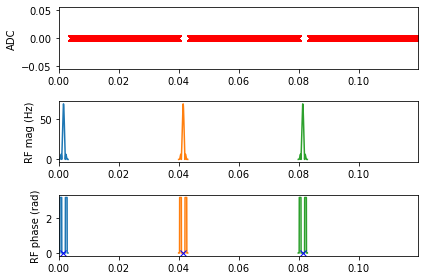

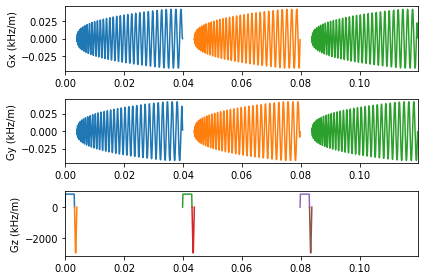

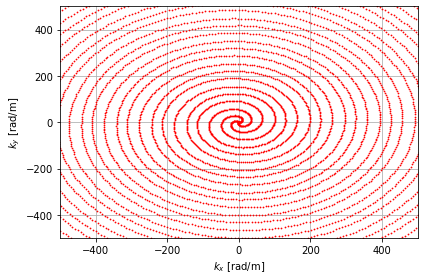

In [42]:
# plot sequence
import matplotlib.pyplot as plt
%matplotlib inline

# plot sequence diagram with pypulseq's plot command
seq.plot(time_disp = 's')

# calculate kspace
ktraj_adc, ktraj, t_excitation, t_refocusing, t_adc = seq.calculate_kspace()

# plot trajectory and zoom in
plt.plot(ktraj_adc[0, :]*1e-3*system.gamma*2*np.pi, ktraj_adc[1, :]*1e-3*system.gamma*2*np.pi, 'r.', markersize=1.5)
plt.xlabel('$k_x$ [rad/m]')
plt.ylabel('$k_y$ [rad/m]')
plt.xlim(-500,500)
plt.ylim(-500,500)
plt.grid()
plt.tight_layout()


# Non cartesian image reconstruction with the BART toolbox

In [43]:
# example reconstruction of a Spiral out spoiled GRE sequence with 15 spiral interleaves
import bart

# read measured signal (Siemens 7T+) and trajectories (Skope clip-on cam)
signal       = np.load('signal_example.npy') # signal format: [1,readout,interleaves,coils]
traj         = np.load('traj_example.npy')   # GIRF-predicted trajectory. format: [dimensions,readout,interleaves]
traj_nominal = np.load('traj_nominal.npy')   # from PyPulseq (as above, but 15 interleaves)

# bart nufft with nominal trajectory
nufft    = bart.bart(1, 'nufft -i -t -l1 0.0001 -d 192:192:1', traj_nominal, signal) # nufft
kspace   = bart.bart(1, 'fft -u 7', nufft)                                        # back to kspace
sens     = bart.bart(1, 'ecalib -m 1 -I', kspace)                                 # ESPIRiT sensitivity map calibration
# parallel imaging with compressed sensing reconstruction
recoN     = bart.bart(1, 'pics -S -e -l1 -r 0.0001 -i50 -t', traj_nominal, signal, sens)
recoN_ksp = bart.bart(1, 'fft -u 7', reco)

# bartnufft with GIRF-predicted trajectory
nufft    = bart.bart(1, 'nufft -i -t -l1 0.0001 -d 192:192:1', traj, signal) # nufft
kspace   = bart.bart(1, 'fft -u 7', nufft)                                   # back to kspace
sens     = bart.bart(1, 'ecalib -m 1 -I', kspace)                            # ESPIRiT sensitivity map calibration
# parallel imaging with compressed sensing reconstruction
recoP     = bart.bart(1, 'pics -S -e -l1 -r 0.0001 -i50 -t', traj, signal, sens)
recoP_ksp = bart.bart(1, 'fft -u 7', reco)

Text(0.5, 1.0, 'GIRF-predicted k(t): k space')

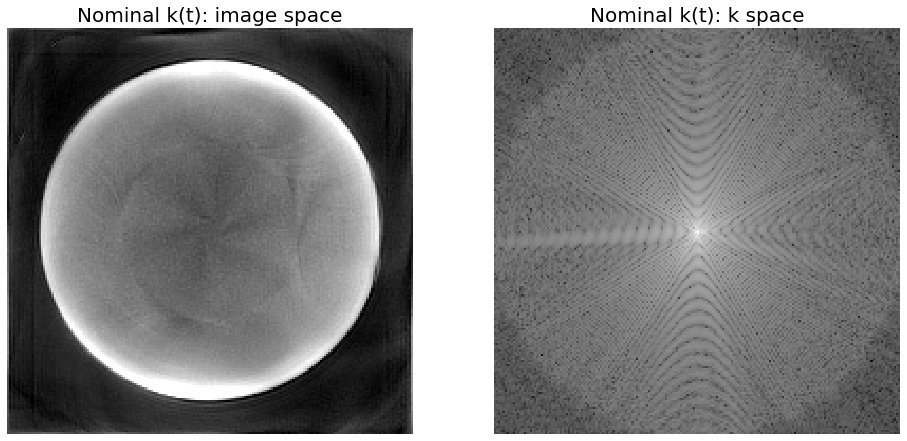

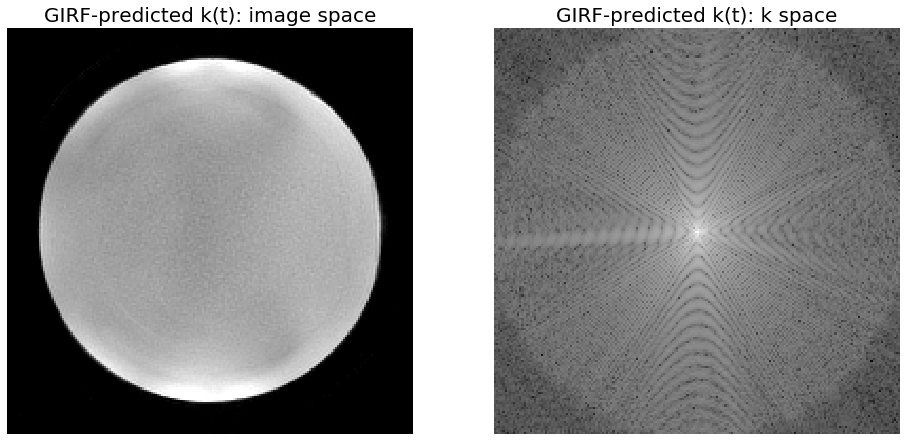

In [44]:
# plot results
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=[16,8])
ax1.imshow(abs(recoN), cmap='gray', vmin=0.1*abs(reco).mean() ,vmax=2.5*abs(reco).mean())
ax1.axis('off')
ax1.set_title('Nominal k(t): image space', fontsize=20)

ax2.imshow(np.log10(abs(recoN_ksp)), cmap='gray')
ax2.axis('off')
ax2.set_title('Nominal k(t): k space', fontsize=20)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=[16,8])
ax1.imshow(abs(recoP), cmap='gray', vmin=0.1*abs(reco).mean() ,vmax=2.5*abs(reco).mean())
ax1.axis('off')
ax1.set_title('GIRF-predicted k(t): image space', fontsize=20)

ax2.imshow(np.log10(abs(recoM_ksp)), cmap='gray')
ax2.axis('off')
ax2.set_title('GIRF-predicted k(t): k space', fontsize=20)